<a href="https://colab.research.google.com/github/souhityac/LSTM-based-NSE-Stock-Predictions/blob/main/LSTM_NSE_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing investpy

!pip install investpy

     |████████████████████████████████| 4.4MB 8.1MB/s 
     |████████████████████████████████| 245kB 39.6MB/s 
     |████████████████████████████████| 5.5MB 36.5MB/s 
     |████████████████████████████████| 512kB 52.2MB/s 
  Created wheel for investpy: filename=investpy-1.0-cp36-none-any.whl size=4465842 sha256=eaaa38b9eb28adba496350f19de84d8d251af1f3aa693adfaec3e642d601c3c0
  Stored in directory: /root/.cache/pip/wheels/ed/a0/ec/5866604d61abe747911c1ecafeea8ac27b5b17670e1191782a
Successfully built investpy
ERROR: convertdate 2.2.0 has requirement pytz<2020,>=2014.10, but you'll have pytz 2020.4 which is incompatible.
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9


In [41]:
def create_data(data):

  data = data[['Open','High','Low','Close']]
  h = data['High'][:3].max()
  l = data['Low'][:3].min()

  sw_high = [h for i in range(3)]
  sw_low = [l for i in range(3)]
  sh_broken = [0 for i in range(3)]
  sl_broken = [0 for i in range(3)]

  for i in range(3,len(data)):
      
      shf,slf = 0,0
      if data['Low'][i-2] > data['Low'][i-1] and data['Low'][i-1] < data['Low'][i]:
          
          if data['Low'][i-1] < l:
              slf=1
          l = data['Low'][i-1]
          
      if data['High'][i-2] < data['High'][i-1] and data['High'][i-1] > data['High'][i]:
          
          if data['High'][i-1] > h:
              shf=1
          h = data['High'][i-1]
          
      sw_high.append(h)
      sw_low.append(l)
      sh_broken.append(shf)
      sl_broken.append(slf)
      
  data['Sw High'] = sw_high
  data['Sw Low'] = sw_low
  data['High Broken'] = sh_broken
  data['Low Broken'] = sl_broken

  return data

In [50]:
# Data Collection 
# HDFC Bank data - January,2016 to Oct,2020
# Timeframe - Daily

import investpy

data = investpy.get_stock_historical_data(stock='HDBK',
                                        country='India',
                                        from_date='01/01/2019',
                                        to_date='30/12/2019')

test = investpy.get_stock_historical_data(stock='HDBK',
                                        country='India',
                                        from_date='01/01/2020',
                                        to_date='31/12/2020')



In [51]:
data = create_data(data)
test = create_data(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
print(data.shape)
print(test.shape)

(244, 8)
(244, 8)


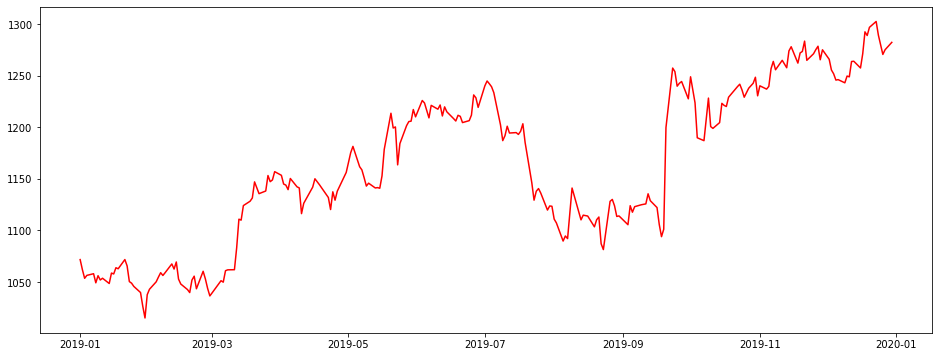

In [53]:
# Plotting the data

import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(data.index,data['Close'], color='red')

In [75]:
# Feature Set of OHLC
X = data.values
val_x = test.values

In [76]:
# Preprocessing the data 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
X_scaled = scaler.transform(X)

sc2 = MinMaxScaler(feature_range=(0,1)).fit(val_x)
scaled_val_x = sc2.transform(val_x)

In [89]:
# Creating the labels
# Setting 'Close' as the label to predict 
Y = data['Close'].values.reshape(-1,1)
yscaler = MinMaxScaler(feature_range=(0,1)).fit(Y)
Y = yscaler.transform(Y)
Y_val = test['Close'].values.reshape(-1,1)
val_y_scaler = MinMaxScaler(feature_range=(0,1)).fit(Y_val)
scaled_val_y = val_y_scaler.transform(Y_val)

In [90]:
# Creating window data: input for time-series model
# Using 2 trading weeks of data as input to predict the next timestep

timestep = 10
xtrain,ytrain = [],[]
val_x,val_y = [],[]

for i in range(timestep, len(X_scaled)):
  xtrain.append(X_scaled[i-timestep:i, :X_scaled.shape[1]])
  ytrain.append(Y[i])

  val_x.append(scaled_val_x[i-timestep:i, :scaled_val_x.shape[1]])
  val_y.append(scaled_val_y[i])

In [91]:
# Converting window data into arrays to pass as input to the model

import numpy as np 
xtrain,ytrain = (np.array(xtrain),np.array(ytrain))
xtrain = np.reshape(xtrain, (xtrain.shape[0],xtrain.shape[1],xtrain.shape[2]))

val_x,val_y = (np.array(val_x),np.array(val_y))
val_x = np.reshape(val_x, (val_x.shape[0],val_x.shape[1],val_x.shape[2]))


In [92]:
print(xtrain.shape)
print(val_x.shape)

(234, 10, 8)
(234, 10, 8)


In [61]:
import time
import warnings
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt

In [82]:
# LSTM Model with 32-32-16 architecture

model = Sequential()

model.add(LSTM(units=32,batch_size=2,input_shape = (10,8),stateful=True,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32,stateful=True,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=16,stateful=True,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (2, 10, 32)               5248      
_________________________________________________________________
dropout_15 (Dropout)         (2, 10, 32)               0         
_________________________________________________________________
lstm_16 (LSTM)               (2, 10, 32)               8320      
_________________________________________________________________
dropout_16 (Dropout)         (2, 10, 32)               0         
_________________________________________________________________
lstm_17 (LSTM)               (2, 16)                   3136      
_________________________________________________________________
dropout_17 (Dropout)         (2, 16)                   0         
_________________________________________________________________
dense_5 (Dense)              (2, 1)                   

In [83]:
# Training the model
# Loss metric: Mean Squared Error

model.fit(xtrain,ytrain,epochs=50,validation_data=(xtrain,ytrain), batch_size=2,verbose=1)

Epoch 1/50
117/117 [==============================] - 4s 14ms/step - loss: 0.1018 - val_loss: 0.0127
Epoch 2/50
117/117 [==============================] - 1s 8ms/step - loss: 0.0246 - val_loss: 0.0108
Epoch 3/50
117/117 [==============================] - 1s 7ms/step - loss: 0.0251 - val_loss: 0.0122
Epoch 4/50
117/117 [==============================] - 1s 7ms/step - loss: 0.0230 - val_loss: 0.0144
Epoch 5/50
117/117 [==============================] - 1s 8ms/step - loss: 0.0204 - val_loss: 0.0098
Epoch 6/50
117/117 [==============================] - 1s 9ms/step - loss: 0.0214 - val_loss: 0.0112
Epoch 7/50
117/117 [==============================] - 1s 9ms/step - loss: 0.0210 - val_loss: 0.0143
Epoch 8/50
117/117 [==============================] - 1s 8ms/step - loss: 0.0267 - val_loss: 0.0192
Epoch 9/50
117/117 [==============================] - 1s 8ms/step - loss: 0.0179 - val_loss: 0.0085
Epoch 10/50
117/117 [==============================] - 1s 9ms/step - loss: 0.0167 - val_loss: 0.009

In [86]:
# Predict for 2019 

predict = model.predict(xtrain, batch_size=2)
predict = predict.reshape(-1,1)
predict = yscaler.inverse_transform(predict)

actual = yscaler.inverse_transform(ytrain)

Text(0, 0.5, 'Close')

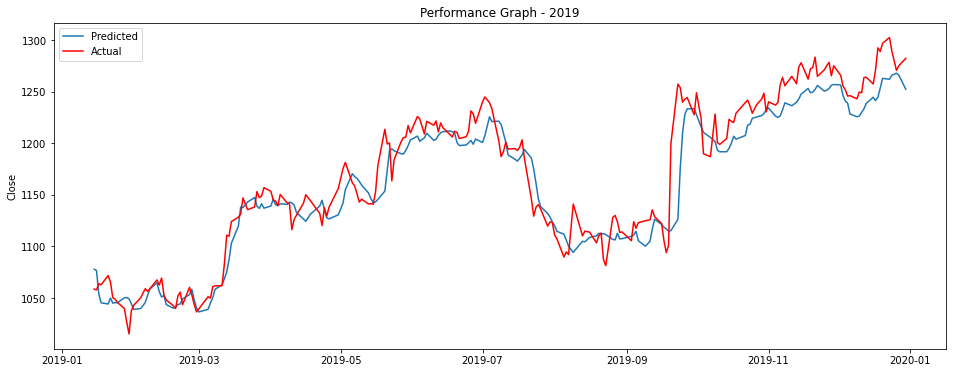

In [87]:
# Plotting the results for 2019

plt.figure(figsize=(16,6))
plt.plot(data.index[10:],predict,label='Predicted')
plt.plot(data.index[10:],actual,label='Actual',color='red')
plt.legend(['Predicted','Actual'])
plt.title('Performance Graph - 2019')
plt.ylabel('Close')

[1350.3857]
[1372.65]


Text(0, 0.5, 'Close')

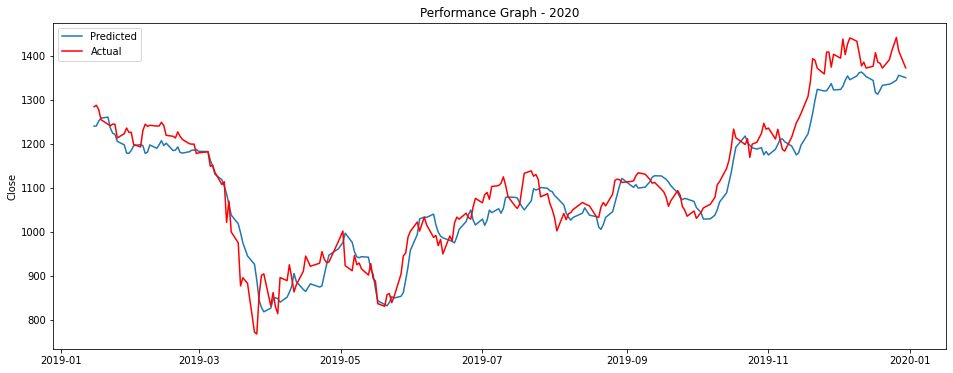

In [97]:
# Predict for 2020 

predict = model.predict(val_x, batch_size=2)

predict = predict.reshape(-1,1)
predict = val_y_scaler.inverse_transform(predict)

actual = val_y_scaler.inverse_transform(val_y)

print(predict[-1])
print(actual[-1])

# Plotting the results for 2020

plt.figure(figsize=(16,6))
plt.plot(data.index[10:],predict,label='Predicted')
plt.plot(data.index[10:],actual,label='Actual',color='red')
plt.legend(['Predicted','Actual'])
plt.title('Performance Graph - 2020')
plt.ylabel('Close')